In [16]:
from google.colab import files
uploaded = files.upload()


Saving Pneumonia_001.png to Pneumonia_001.png
Saving Pneumonia_002.png to Pneumonia_002.png
Saving Pneumonia_003.png to Pneumonia_003.png
Saving Pneumonia_004.png to Pneumonia_004.png
Saving Pneumonia_005.png to Pneumonia_005.png
Saving Pneumonia_006.png to Pneumonia_006.png
Saving Pneumonia_007.png to Pneumonia_007.png
Saving Pneumonia_008.png to Pneumonia_008.png
Saving Pneumonia_009.png to Pneumonia_009.png
Saving Pneumonia_010.png to Pneumonia_010.png
Saving Pneumonia_011.png to Pneumonia_011.png
Saving Pneumonia_012.png to Pneumonia_012.png
Saving Pneumonia_013.png to Pneumonia_013.png
Saving Pneumonia_014.png to Pneumonia_014.png
Saving Pneumonia_015.png to Pneumonia_015.png
Saving Pneumonia_016.png to Pneumonia_016.png
Saving Pneumonia_017.png to Pneumonia_017.png
Saving Pneumonia_018.png to Pneumonia_018.png
Saving Pneumonia_019.png to Pneumonia_019.png
Saving Pneumonia_020.png to Pneumonia_020.png
Saving Pneumonia_021.png to Pneumonia_021.png
Saving Pneumonia_022.png to Pneumo

In [ ]:
import os
import zipfile

os.makedirs("originals", exist_ok=True)
for filename in uploaded.keys():
    # Check if the file exists in the original location before attempting to move
    original_path = os.path.join("/content", filename)
    if os.path.exists(original_path) and not zipfile.is_zipfile(original_path):
        os.rename(original_path, os.path.join("originals", filename))

print("Stored", len(os.listdir("originals")), "original images")

✅ Stored 29 original images


In [ ]:
import cv2
import os

os.makedirs("blurred", exist_ok=True)
os.makedirs("enhanced", exist_ok=True)

for fname in os.listdir("originals"):
    path = os.path.join("originals", fname)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        continue

    # A) Blurred version
    blurred = cv2.GaussianBlur(img, (7, 7), 3)  # slightly smaller kernel, less blur
    cv2.imwrite(os.path.join("blurred", fname), blurred)

    # B) Enhanced version
    # Step 1: Denoise (reduce noise but keep edges)
    denoised = cv2.fastNlMeansDenoising(blurred, None, h=20, templateWindowSize=7, searchWindowSize=21)

    # Step 2: Sharpen using unsharp masking
    gaussian = cv2.GaussianBlur(denoised, (7, 7), 5.0)
    sharpened = cv2.addWeighted(denoised, 1.8, gaussian, -0.8, 0)  # stronger sharpening

    # Step 3: Boost local contrast with CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    enhanced = clahe.apply(sharpened)

    cv2.imwrite(os.path.join("enhanced", fname), enhanced)

print("Blurred images saved in /blurred")
print("Enhanced (clearer) images saved in /enhanced")


✅ Blurred images saved in /blurred
✅ Enhanced (clearer) images saved in /enhanced


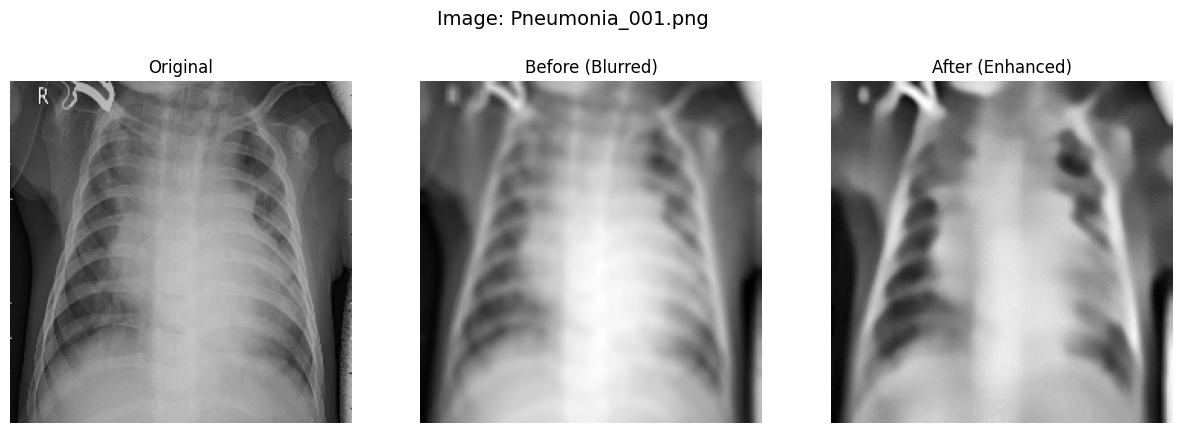

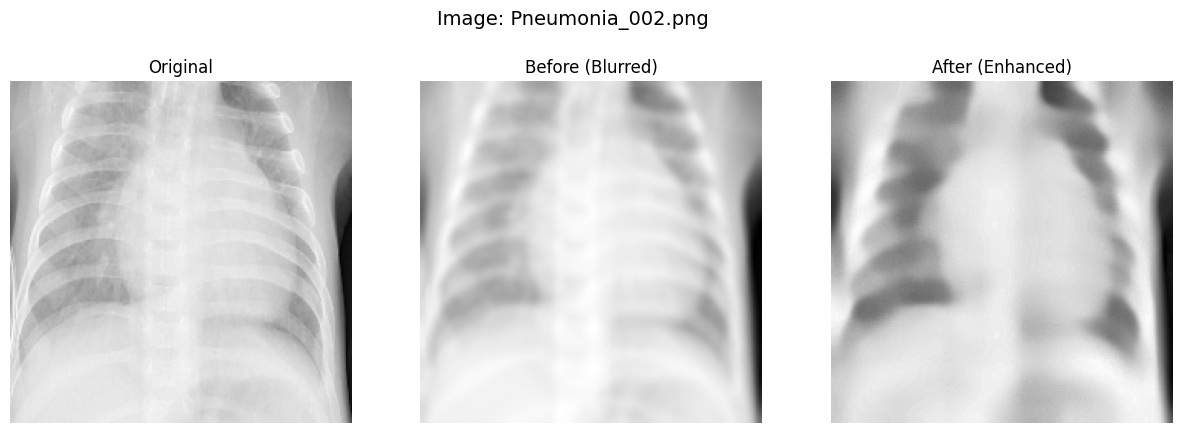

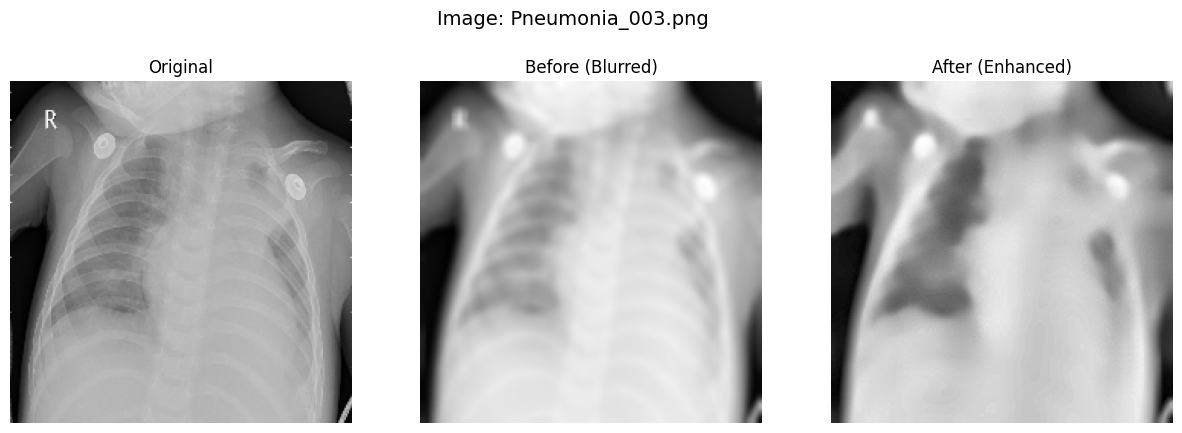

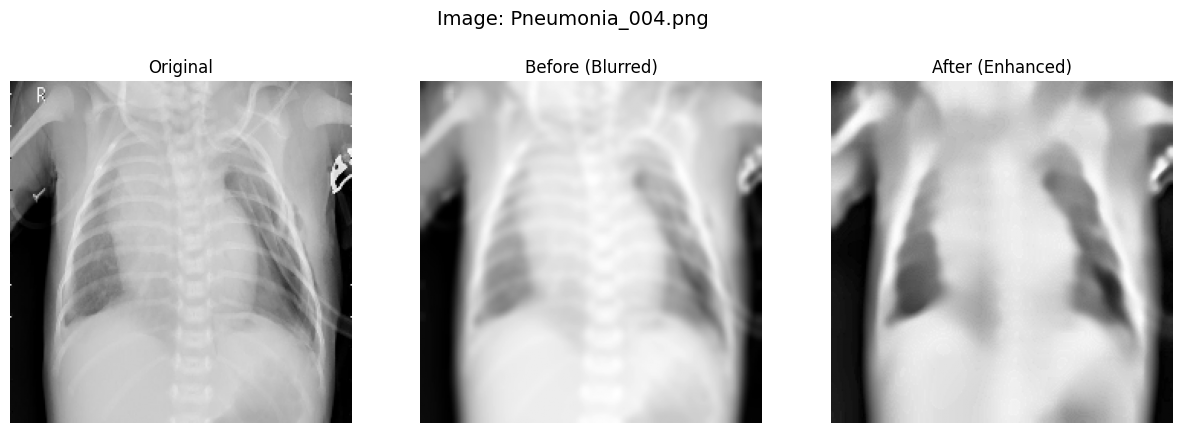

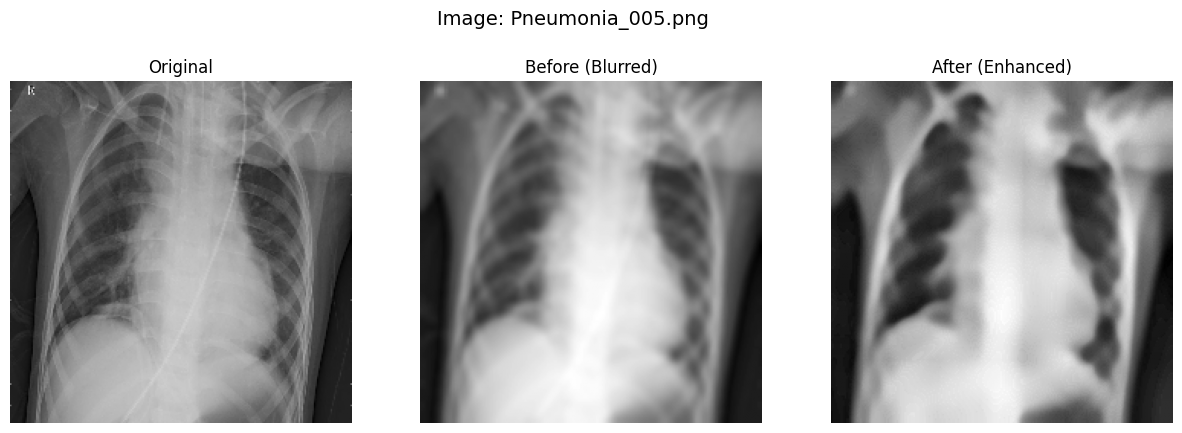

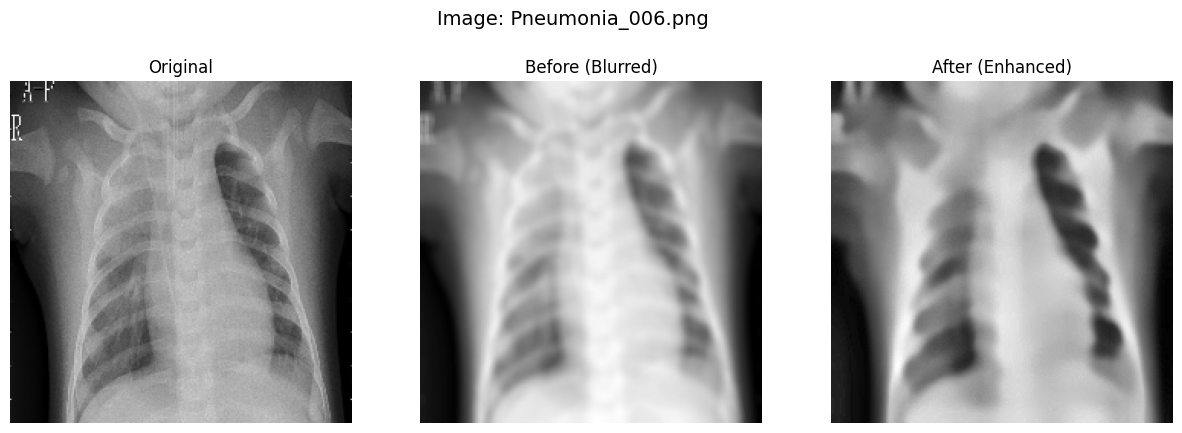

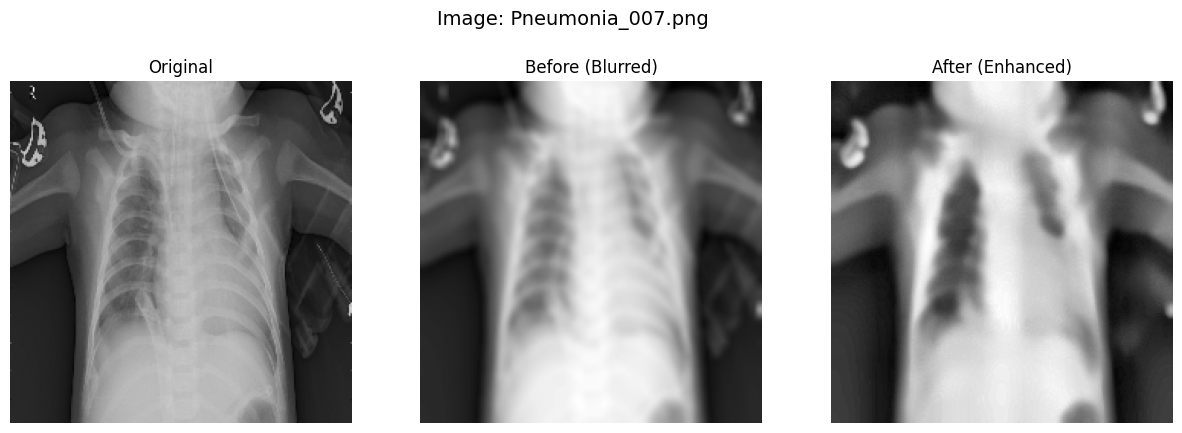

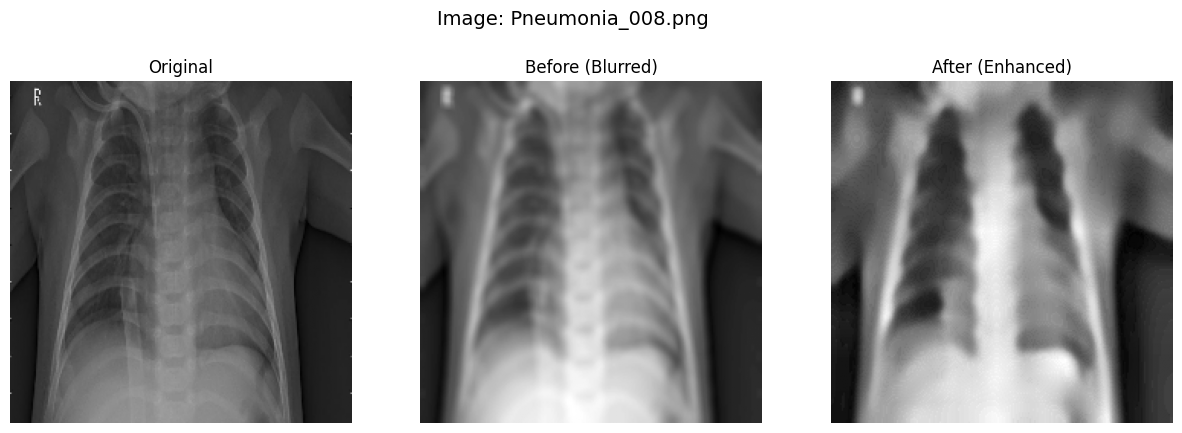

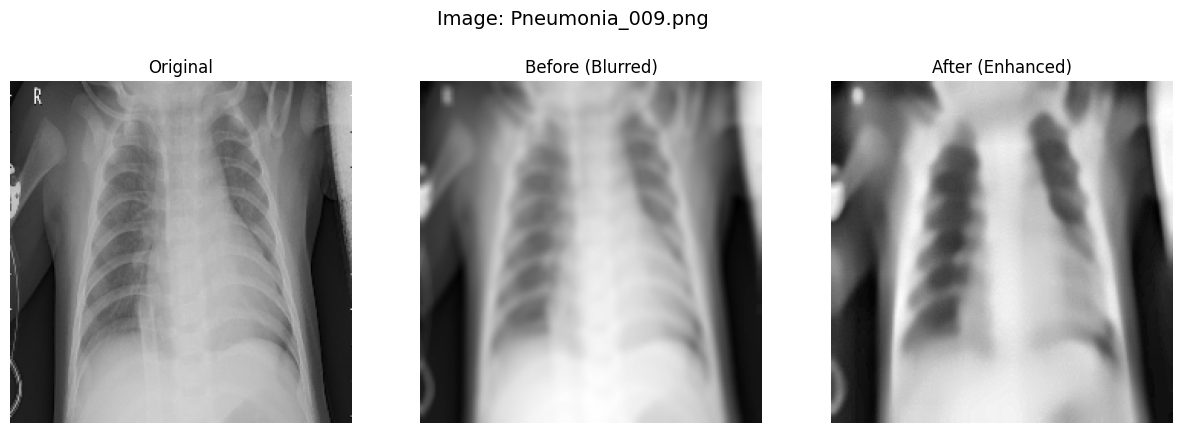

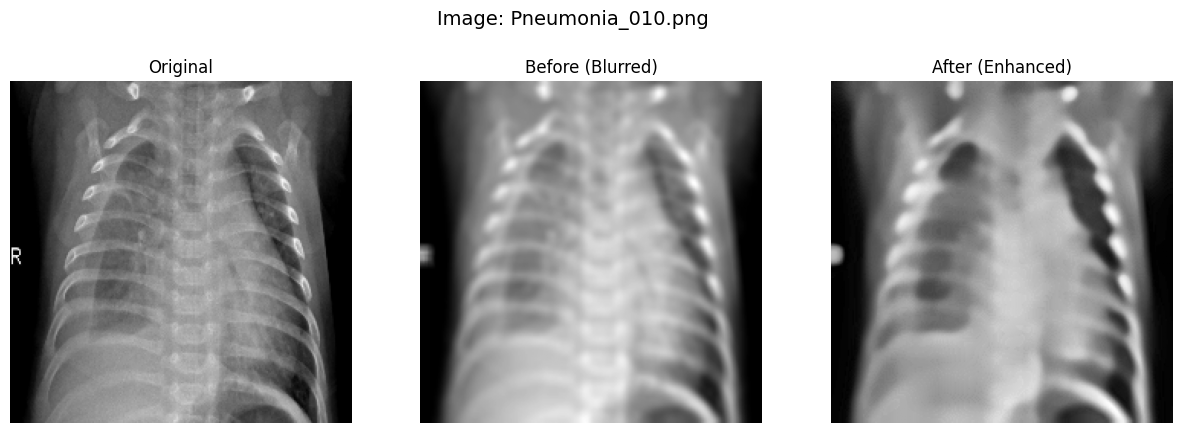

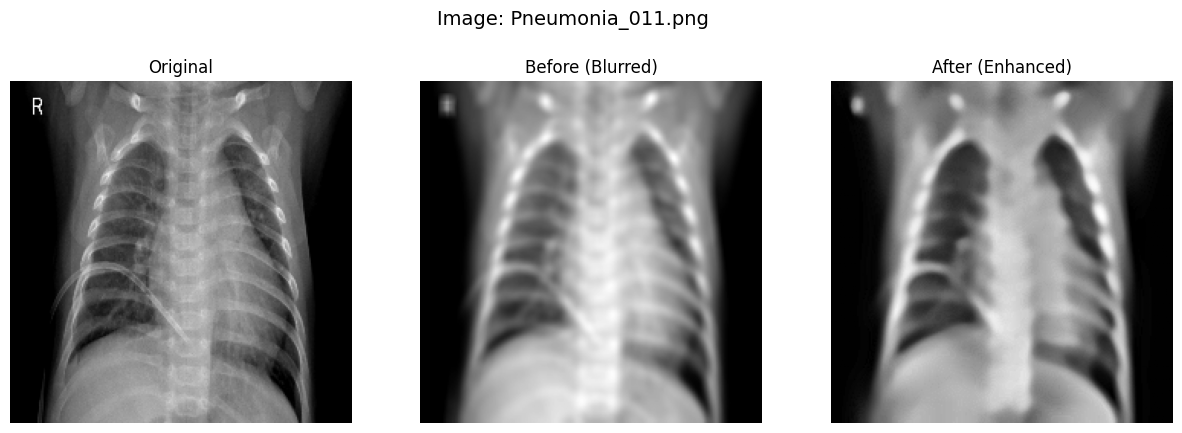

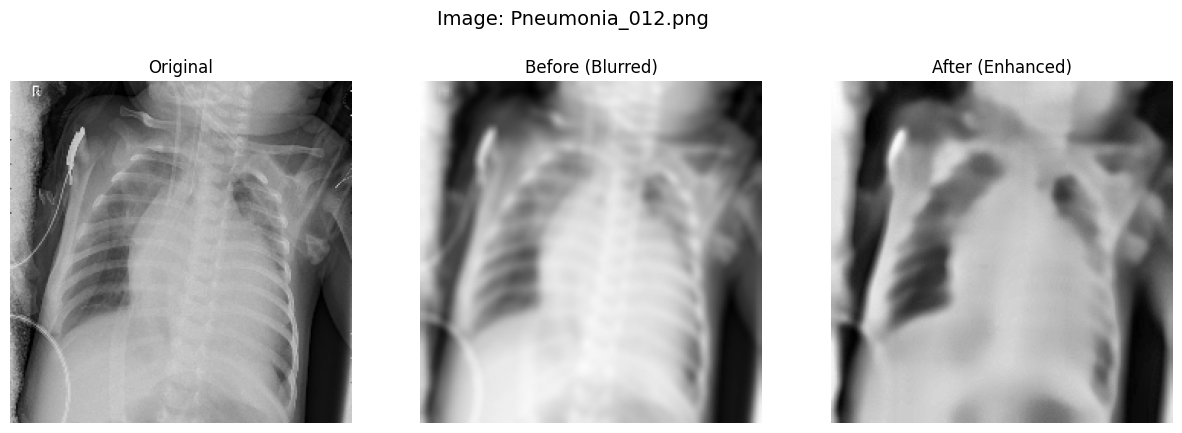

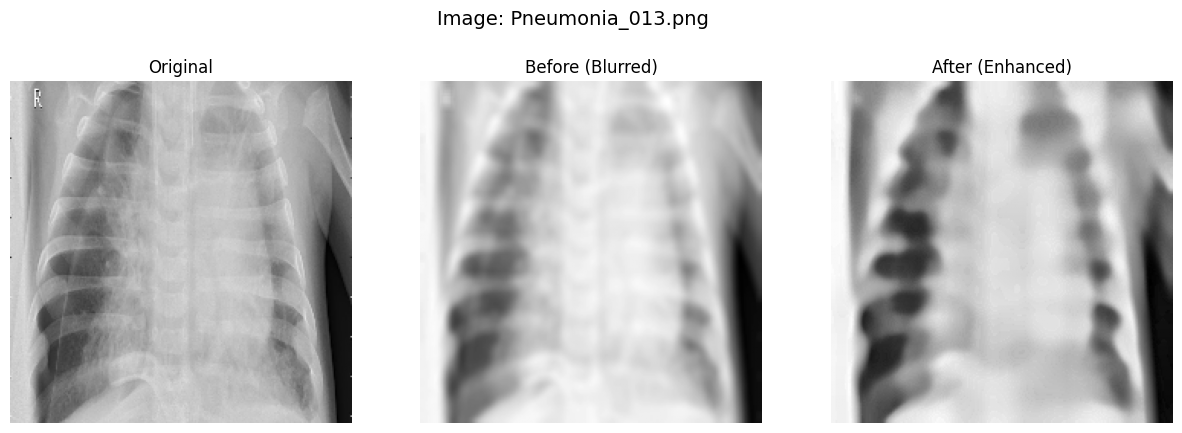

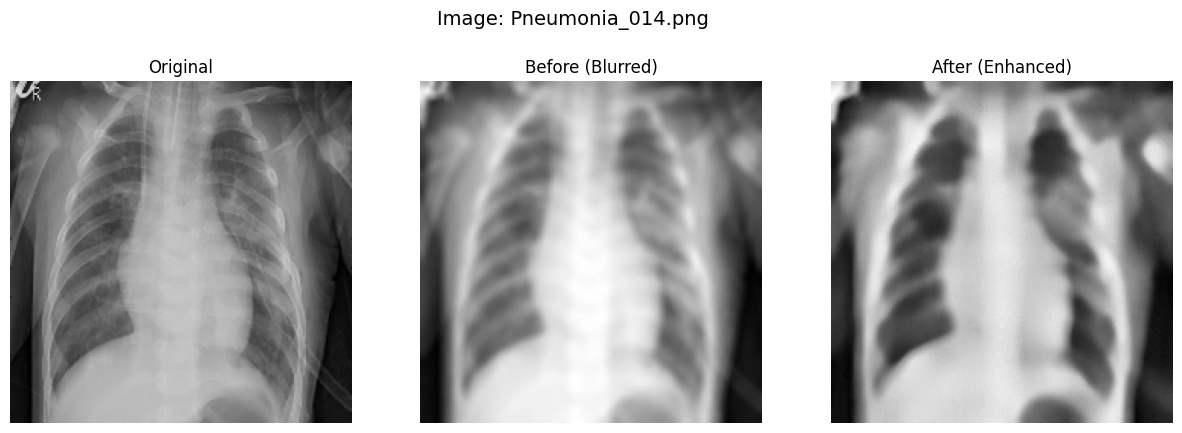

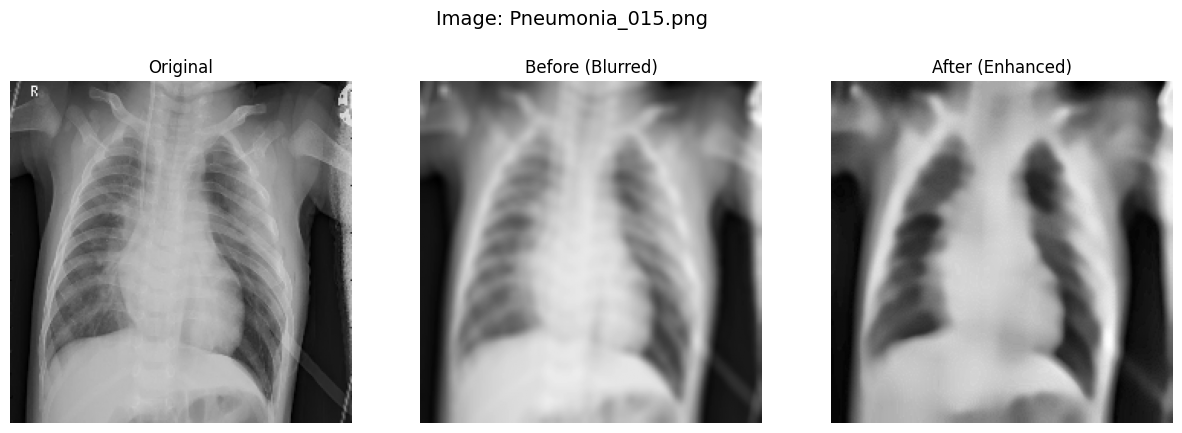

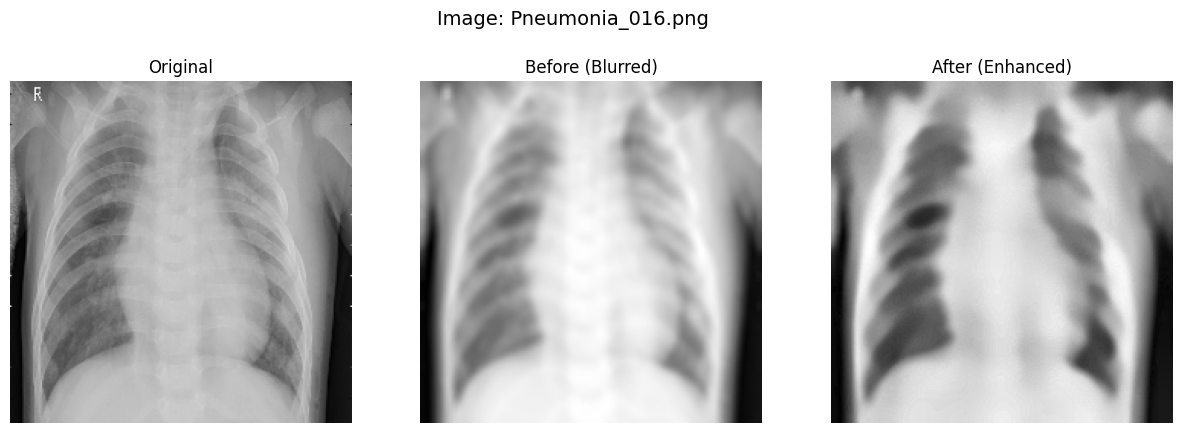

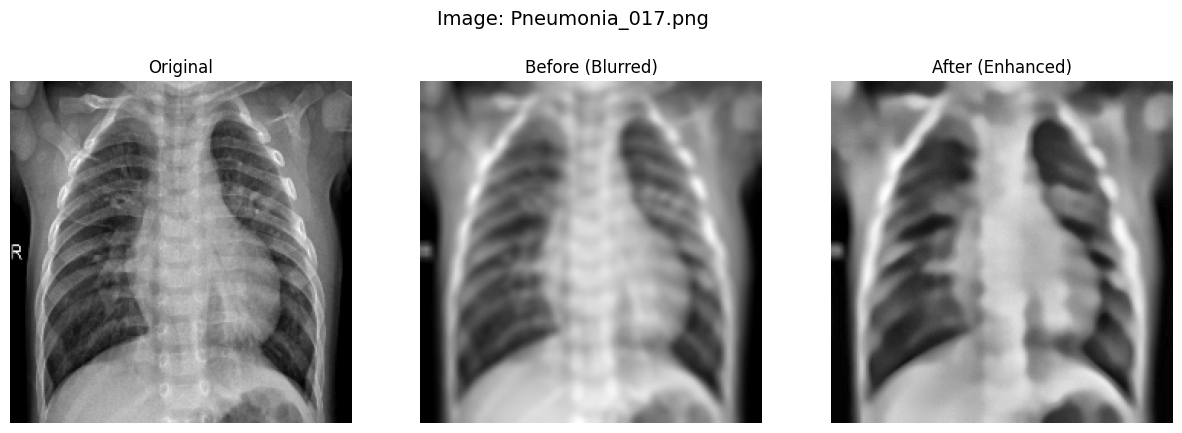

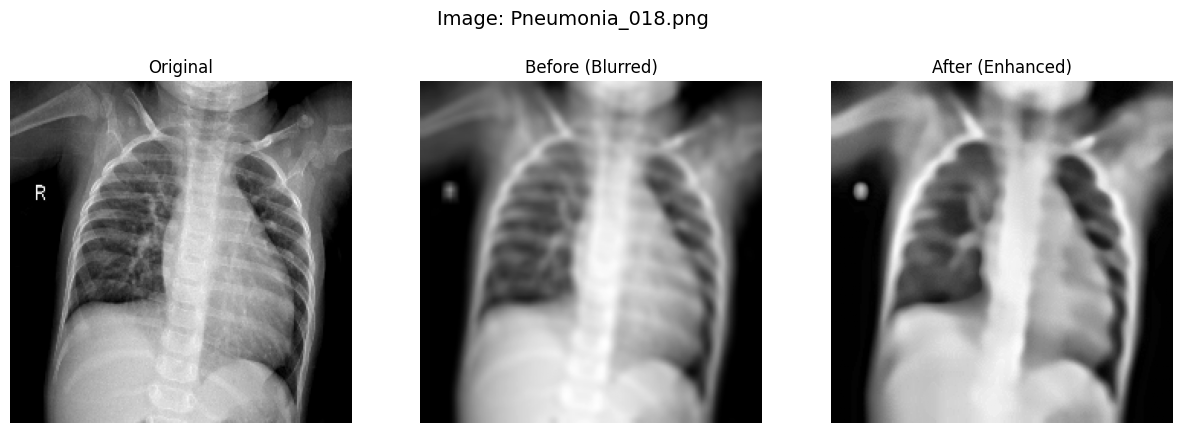

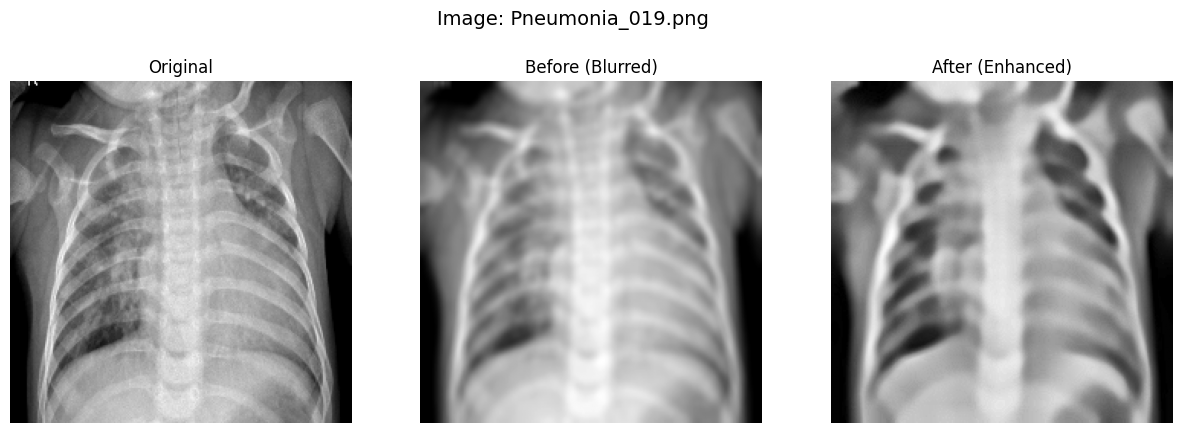

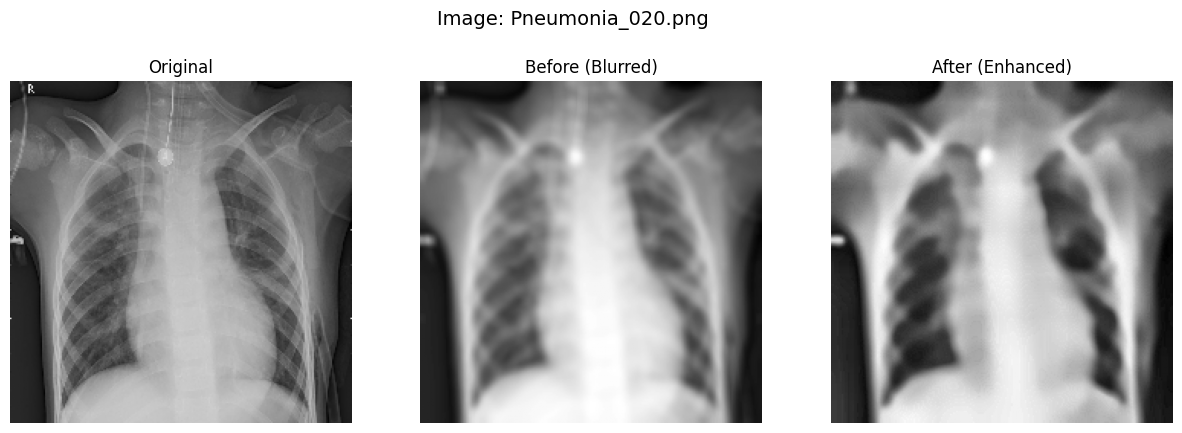

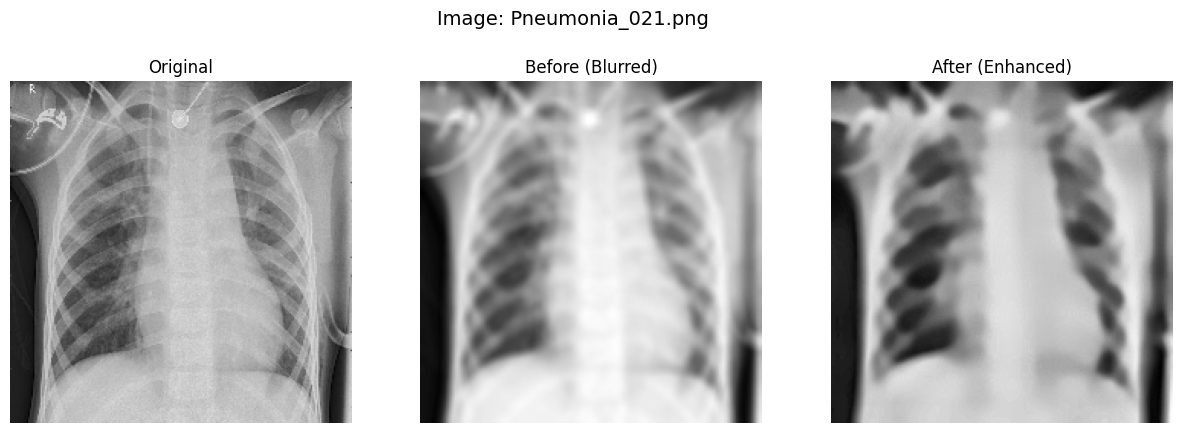

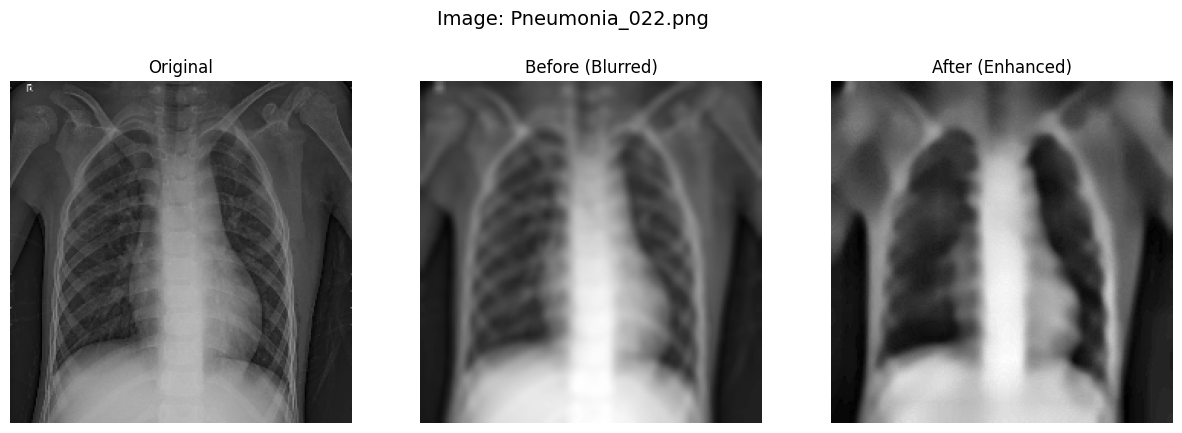

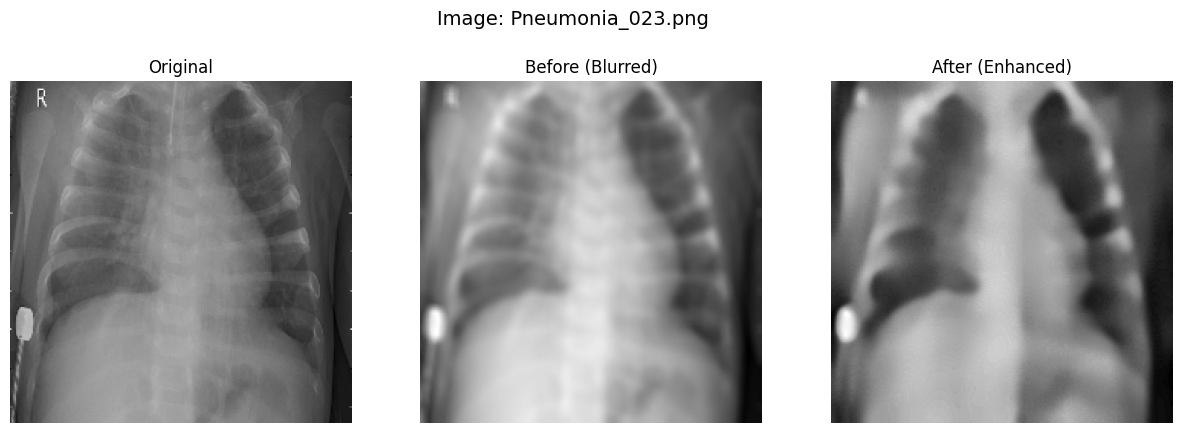

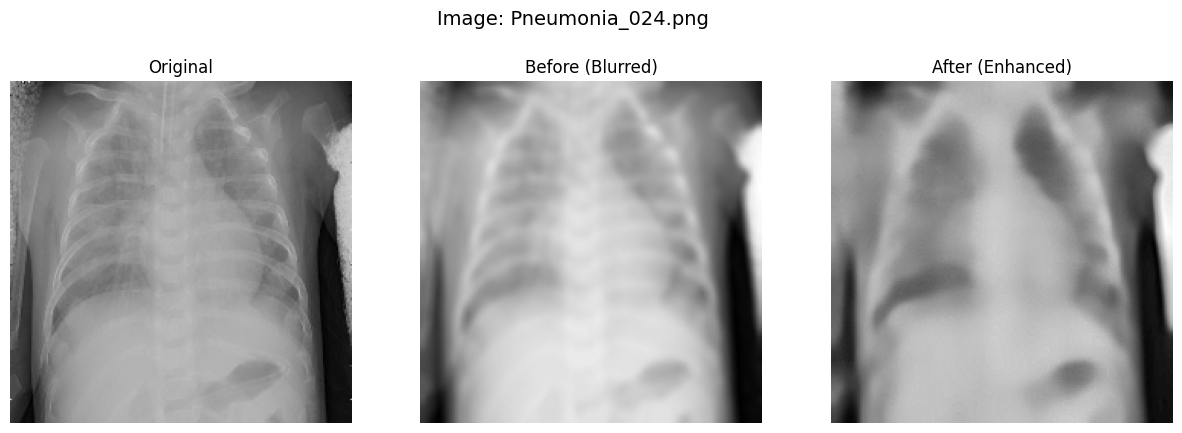

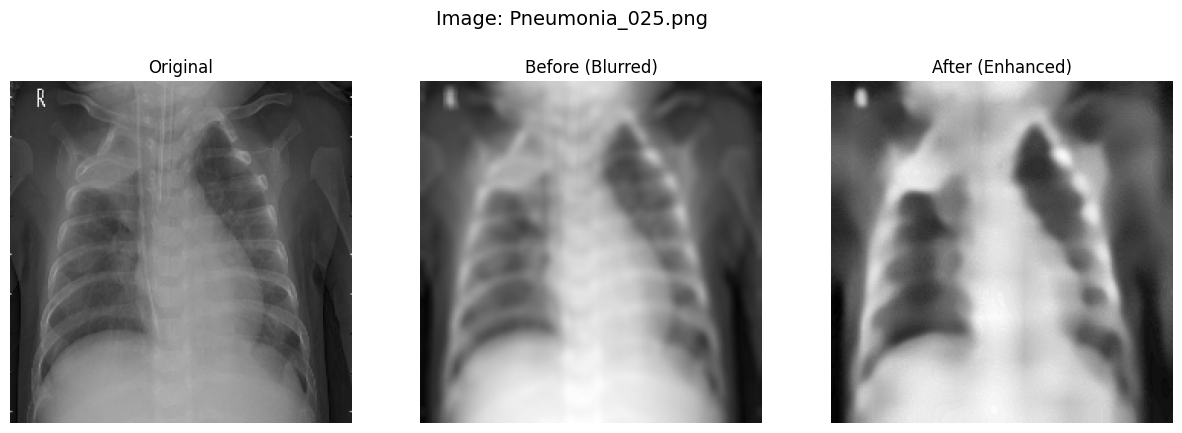

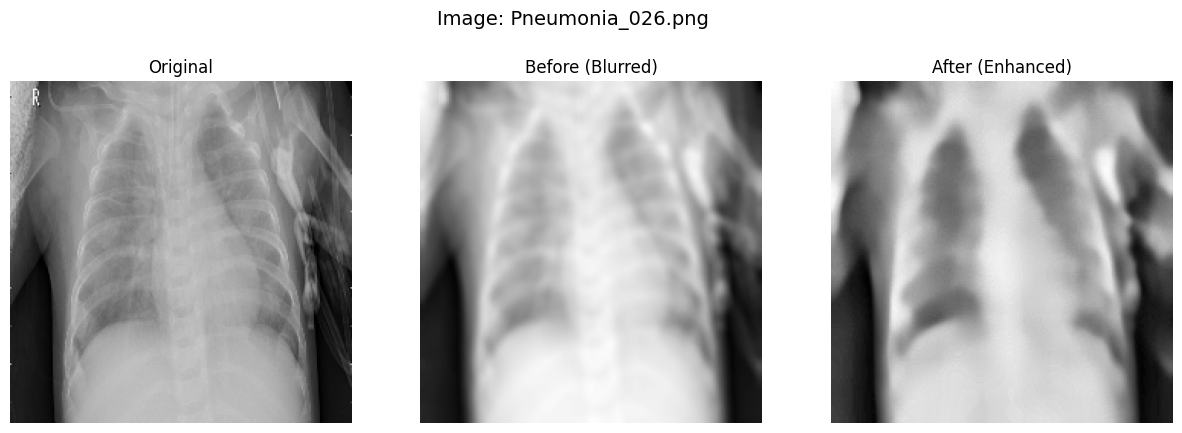

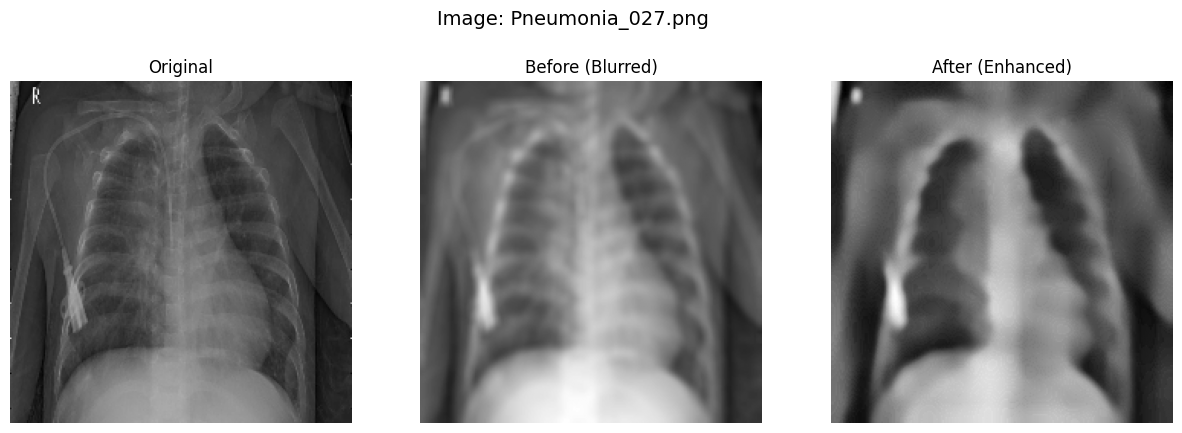

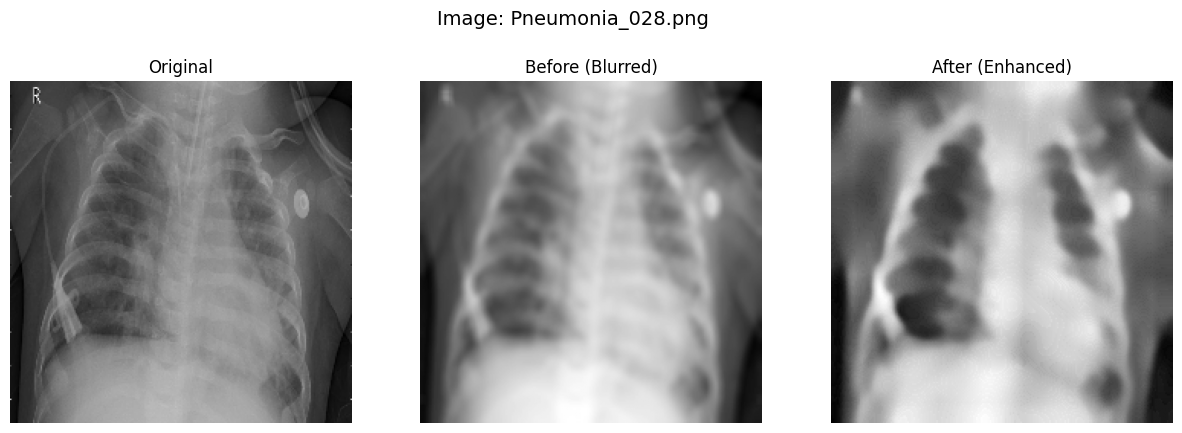

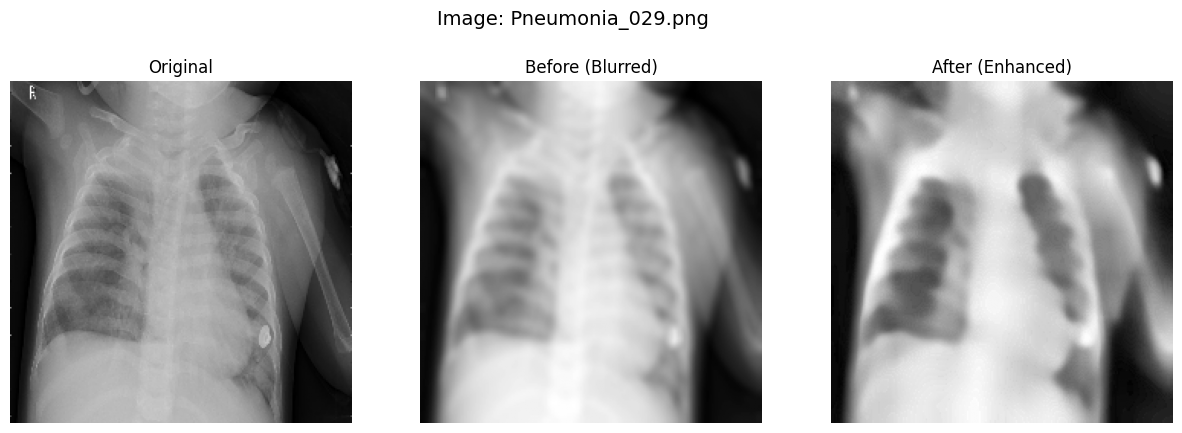

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

original_files = sorted(os.listdir("originals"))

for fname in original_files:
    orig = cv2.imread(os.path.join("originals", fname), cv2.IMREAD_GRAYSCALE)
    blur = cv2.imread(os.path.join("blurred", fname), cv2.IMREAD_GRAYSCALE)
    enh = cv2.imread(os.path.join("enhanced", fname), cv2.IMREAD_GRAYSCALE)

    if orig is None or blur is None or enh is None:
        continue

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(orig, cmap="gray")
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(blur, cmap="gray")
    axs[1].set_title("Before (Blurred)")
    axs[1].axis("off")

    axs[2].imshow(enh, cmap="gray")
    axs[2].set_title("After (Enhanced)")
    axs[2].axis("off")

    plt.suptitle(f"Image: {fname}", fontsize=14)
    plt.show()

In [20]:
import os
import zipfile
from google.colab import files

# Create a zip file of the enhanced images
zip_filename = "enhanced_images.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, filenames in os.walk("enhanced"):
        for filename in filenames:
            zipf.write(os.path.join(root, filename), os.path.relpath(os.path.join(root, filename), "enhanced"))

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.utils import ImageReader

# Make a temporary folder for plots
os.makedirs("report_plots", exist_ok=True)

results = []  # store metrics for summary

original_files = sorted(os.listdir("originals"))

for idx, fname in enumerate(original_files):
    orig = cv2.imread(os.path.join("originals", fname), cv2.IMREAD_GRAYSCALE)
    blur = cv2.imread(os.path.join("blurred", fname), cv2.IMREAD_GRAYSCALE)
    enh  = cv2.imread(os.path.join("enhanced", fname), cv2.IMREAD_GRAYSCALE)

    if orig is None or blur is None or enh is None:
        continue

    # Resize blurred/enhanced
    blur = cv2.resize(blur, (orig.shape[1], orig.shape[0]))
    enh  = cv2.resize(enh, (orig.shape[1], orig.shape[0]))

    # Metrics
    psnr_blur = psnr(orig, blur)
    psnr_enh  = psnr(orig, enh)
    ssim_blur = ssim(orig, blur)
    ssim_enh  = ssim(orig, enh)

    # Delta values (improvement)
    delta_psnr = psnr_enh - psnr_blur
    delta_ssim = ssim_enh - ssim_blur

    results.append([fname, psnr_blur, ssim_blur, psnr_enh, ssim_enh, delta_psnr, delta_ssim])

    # Plot for PDF
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    axs[0].imshow(orig, cmap="gray")
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(blur, cmap="gray")
    axs[1].set_title(f"Blurred\nPSNR: {psnr_blur:.2f} dB\nSSIM: {ssim_blur:.3f}")
    axs[1].axis("off")

    axs[2].imshow(enh, cmap="gray")
    axs[2].set_title(
        f"Enhanced\nPSNR: {psnr_enh:.2f} dB\nSSIM: {ssim_enh:.3f}\n"
        f"ΔPSNR: {delta_psnr:.2f} dB\nΔSSIM: {delta_ssim:.3f}"
    )
    axs[2].axis("off")

    plt.suptitle(f"Validation Results for {fname}", fontsize=14)
    plot_path = f"report_plots/{idx}_{fname}.png"
    plt.savefig(plot_path)
    plt.close()

# Create PDF
pdf_path = "Validation_Report.pdf"
c = canvas.Canvas(pdf_path, pagesize=A4)
width, height = A4

for idx, fname in enumerate(original_files):
    plot_path = f"report_plots/{idx}_{fname}.png"
    if os.path.exists(plot_path):
        img = ImageReader(plot_path)
        c.drawImage(img, 30, 100, width-60, height-150)  # fit nicely
        c.showPage()

c.save()
print(f" Report saved as {pdf_path}")


✅ Report saved as Validation_Report.pdf


In [24]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Convert the results list to a pandas DataFrame
results_df = pd.DataFrame(results, columns=["Filename", "PSNR(Blur)", "SSIM(Blur)", "PSNR(Enh)", "SSIM(Enh)", "Delta PSNR", "Delta SSIM"])

# Save the DataFrame to a CSV file
csv_filename = "image_analysis_results.csv"
results_df.to_csv(csv_filename, index=False)

print(f" Results saved to {csv_filename}")

✅ Results saved to image_analysis_results.csv


In [30]:
from google.colab import files

# Download the CSV file
files.download("image_analysis_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.utils import ImageReader

# Make a temporary folder for plots
os.makedirs("report_plots", exist_ok=True)

results = []  # store metrics for summary

original_files = sorted(os.listdir("originals"))

for idx, fname in enumerate(original_files):
    orig = cv2.imread(os.path.join("originals", fname), cv2.IMREAD_GRAYSCALE)
    blur = cv2.imread(os.path.join("blurred", fname), cv2.IMREAD_GRAYSCALE)
    enh  = cv2.imread(os.path.join("enhanced", fname), cv2.IMREAD_GRAYSCALE)

    if orig is None or blur is None or enh is None:
        continue

    # Resize blurred/enhanced
    blur = cv2.resize(blur, (orig.shape[1], orig.shape[0]))
    enh  = cv2.resize(enh, (orig.shape[1], orig.shape[0]))

    # Metrics
    psnr_blur = psnr(orig, blur)
    psnr_enh  = psnr(orig, enh)
    ssim_blur = ssim(orig, blur)
    ssim_enh  = ssim(orig, enh)

    # Delta values (improvement)
    delta_psnr = psnr_enh - psnr_blur
    delta_ssim = ssim_enh - ssim_blur

    results.append([fname, psnr_blur, ssim_blur, psnr_enh, ssim_enh, delta_psnr, delta_ssim])

    # Plot for PDF
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    axs[0].imshow(orig, cmap="gray")
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(blur, cmap="gray")
    axs[1].set_title(f"Blurred\nPSNR: {psnr_blur:.2f} dB\nSSIM: {ssim_blur:.3f}")
    axs[1].axis("off")

    axs[2].imshow(enh, cmap="gray")
    axs[2].set_title(
        f"Enhanced\nPSNR: {psnr_enh:.2f} dB\nSSIM: {ssim_enh:.3f}\n"
        f"ΔPSNR: {delta_psnr:.2f} dB\nΔSSIM: {delta_ssim:.3f}"
    )
    axs[2].axis("off")

    plt.suptitle(f"Validation Results for {fname}", fontsize=14)
    plot_path = f"report_plots/{idx}_{fname}.png"
    plt.savefig(plot_path)
    plt.close()

# Create PDF
pdf_path = "Validation_Report.pdf"
c = canvas.Canvas(pdf_path, pagesize=A4)
width, height = A4

for idx, fname in enumerate(original_files):
    plot_path = f"report_plots/{idx}_{fname}.png"
    if os.path.exists(plot_path):
        img = ImageReader(plot_path)
        c.drawImage(img, 30, 100, width-60, height-150)  # fit nicely
        c.showPage()

c.save()
print(f" Report saved as {pdf_path}")




✅ Report saved as Validation_Report.pdf


In [32]:
import os
import zipfile
from google.colab import files

# Create a zip file of the comparison plots
zip_filename = "comparison_images.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, _, filenames in os.walk("report_plots"):
        for filename in filenames:
            zipf.write(os.path.join(root, filename), os.path.relpath(os.path.join(root, filename), "report_plots"))

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
from google.colab import files
files.download("Validation_Report.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install reportlab